In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c coder-49140-season-finale

  0% 0.00/6.81M [00:00<?, ?B/s]
100% 6.81M/6.81M [00:00<00:00, 78.3MB/s]


In [ ]:
!unzip coder-49140-season-finale.zip

Archive:  coder-49140-season-finale.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d shubhammeshram579/bank-customer-churn-prediction

Dataset URL: https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction
License(s): CC0-1.0
  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 99.6MB/s]


In [ ]:
!unzip bank-customer-churn-prediction.zip

Archive:  bank-customer-churn-prediction.zip
  inflating: Churn_Modelling.csv     


In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier,Pool,utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from functools import partial
from skopt import space
from skopt import gp_minimize
from sklearn import model_selection
from sklearn.utils import resample
from scipy import stats

# **PreProcess**

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.shape

(165034, 14)

In [ ]:
id = test['id']

In [ ]:
train = train.drop_duplicates(subset=["Surname","CustomerId"],keep="first")

In [ ]:
numerical_cols= ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary','Exited']

In [ ]:
extra = pd.read_csv('Churn_Modelling.csv')

In [ ]:
extra.columns = train.columns
extra_ones = extra.loc[extra.Exited==1].copy()
train = pd.concat([train,extra_ones])

In [ ]:
train["Exited"].value_counts()

Exited
0    104218
1     30384
Name: count, dtype: int64

In [ ]:
# train = train[(np.abs(stats.zscore(train[numerical_cols])) < 3).all(axis=1)]

In [ ]:
train.shape

(134602, 14)

In [ ]:
def preprocess(df):
  df = df.drop(columns = ["id","Surname"])
  df["Gender"] = df["Gender"].astype("category").cat.codes
  df["Geography"] = df["Geography"].astype("category").cat.codes
  return df

In [ ]:
train = preprocess(train)
test = preprocess(test)

In [ ]:
exited = train[train.Exited==1]
no_exit = train[train.Exited == 0]
upsampled_exited = resample(no_exit, replace=True, n_samples=40681)
train = pd.concat([upsampled_exited,exited])

In [ ]:
train = train.sample(frac=1)

In [ ]:
train.drop(columns=["CustomerId"],inplace=True)

In [ ]:
train['Exited'].value_counts()

Exited
0    40681
1    30384
Name: count, dtype: int64

In [ ]:
X = train.drop(columns=["Exited"])
y = train["Exited"]

# **Exploit Data**

In [ ]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.006164,0.007600,-0.015354,0.000886,0.007526,0.013408,-0.009202,0.018661,-0.006283,-0.039181
Geography,0.006164,1.000000,-0.017554,0.040288,-0.004813,0.159470,-0.020266,-0.019468,-0.009475,-0.000540,0.070886
Gender,0.007600,-0.017554,1.000000,-0.089786,0.008831,-0.018352,0.041686,0.001566,0.051850,-0.010212,-0.188819
Age,-0.015354,0.040288,-0.089786,1.000000,-0.011143,0.081257,-0.125446,-0.012668,-0.053827,0.008791,0.433740
Tenure,0.000886,-0.004813,0.008831,-0.011143,1.000000,-0.014865,0.011082,-0.000523,-0.004815,0.000804,-0.024811
Balance,0.007526,0.159470,-0.018352,0.081257,-0.014865,1.000000,-0.272142,-0.023905,-0.031674,0.006881,0.163324
NumOfProducts,0.013408,-0.020266,0.041686,-0.125446,0.011082,-0.272142,1.000000,0.006484,0.062865,-0.009303,-0.239716
HasCrCard,-0.009202,-0.019468,0.001566,-0.012668,-0.000523,-0.023905,0.006484,1.000000,-0.029736,0.009048,-0.030249
IsActiveMember,0.018661,-0.009475,0.051850,-0.053827,-0.004815,-0.031674,0.062865,-0.029736,1.000000,-0.008645,-0.254774
EstimatedSalary,-0.006283,-0.000540,-0.010212,0.008791,0.000804,0.006881,-0.009303,0.009048,-0.008645,1.000000,0.016151


In [ ]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
138625,718,1,0,35.0,9,133871.05,2,0.0,0.0,15360.91,1
45413,663,0,0,43.0,5,0.00,2,1.0,1.0,153536.24,0
2254,474,0,0,40.0,4,0.00,2,1.0,0.0,103726.71,0
1757,523,1,0,39.0,1,143903.11,1,1.0,1.0,118711.75,1
64306,718,0,0,51.0,5,109109.33,3,1.0,0.0,108528.56,1


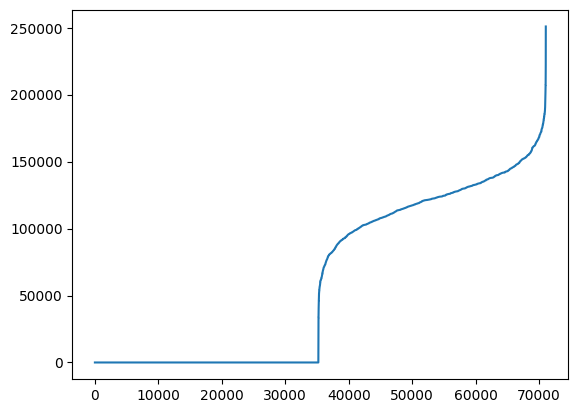

In [ ]:
plt.plot(X["Balance"].sort_values().reset_index(drop=True))

# **Fine Tune**

In [ ]:
def optimize(param,param_names,X,y):
  params = dict(zip(param_names,param))
  params["verbose"] = False
  params["task_type"]="GPU"
  model = CatBoostClassifier(**params)
  kf = model_selection.KFold(n_splits=5)
  scores = []
  for idx in kf.split(X=X,y=y):
    train_idx,test_idx = idx[0],idx[1]
    X_train,X_test = X.iloc[train_idx],X.iloc[test_idx]
    y_train,y_test = y.iloc[train_idx],y.iloc[test_idx]
    train_pool = Pool(X_train,y_train)
    test_pool = Pool(X_test,y_test)
    model.fit(train_pool)
    (fpr, tpr, thresholds) = utils.get_roc_curve(model,test_pool,plot=False)
    score = auc(fpr,tpr)
    scores.append(score)
  return -1.0 * np.mean(scores)

In [ ]:
params_space = [
    space.Integer(50,300,name='iterations'),
    space.Real(0.1,0.4,prior="uniform",name='learning_rate'),
    space.Integer(150,300,name="leaf_estimation_iterations"),
    space.Integer(5,14,name="depth"),
    space.Categorical(["Logloss"],name="loss_function")
]
param_names=['iterations','learning_rate','leaf_estimation_iterations','depth','loss_function']

In [ ]:
optimization_function = partial(optimize,param_names=param_names,X=X,y=y)

In [ ]:
result = gp_minimize(optimization_function,dimensions= params_space,n_calls=15,n_random_starts=15,verbose=15)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 98.5141
Function value obtained: -0.8978
Current minimum: -0.8978
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.9522
Function value obtained: -0.9016
Current minimum: -0.9016
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 179.9038
Function value obtained: -0.8911
Current minimum: -0.9016
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 234.3339
Function value obtained: -0.8895
Current minimum: -0.9016
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.1689
Function value obtained: -0.9009
Current minimum: -0.9016
Iteration No: 6 st

In [ ]:
recommended = dict(zip(param_names,result.x))

In [ ]:
recommended

{'iterations': 72,
 'learning_rate': 0.17570970812124373,
 'leaf_estimation_iterations': 169,
 'depth': 6,
 'loss_function': 'Logloss'}

# **Train**

In [ ]:
model = CatBoostClassifier(**recommended)

In [ ]:
x_train , x_val , y_train , y_val = train_test_split(X,y,test_size=0.2)

In [ ]:
model.fit(x_train,y_train,verbose=False)

In [ ]:
pred = model.predict(x_val)
fpr, tpr, thresholds = roc_curve(y_val,pred)

In [ ]:
f"{len(pred)} - {np.count_nonzero(pred)} = {len(pred)-np.count_nonzero(pred)}"

'14213 - 5703 = 8510'

In [ ]:
y_val.value_counts()

Exited
0    8148
1    6065
Name: count, dtype: int64

In [ ]:
auc(fpr,tpr)

0.8162853047152008

In [ ]:
submit = pd.DataFrame({"id":id,"Exited":model.predict(test)})

In [ ]:
submit.to_csv("submit.csv",index=False)

In [ ]:
# https://www.kaggle.com/code/diaakotb/bank-churn-eda-and-prediction-rfc-94

In [ ]:
!kaggle competitions submit -c coder-49140-season-finale -f submit.csv -m "first submission"

100% 967k/967k [00:00<00:00, 1.82MB/s]
Successfully submitted to Coder 49140 - Season Finale